In [5]:
import pdb
import numpy as np
import policy_gradient_reinforce as policy_gradient
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
# Morvan's code is against TF 1.0
tf.disable_v2_behavior() 

# Each policy can only increase, decrease, or stay by a certain ACTION_DELTA.
NUM_ACTION = 3

# TODO: Tweak all the parameters below per optimization problem
ACTION_DELTA = 0.1
# How many timesteps to look back for state. Ke li 2017 used 25.
NUM_TIMESTEPS_FOR_STATE = 2
# The number of episodes / full game. Each episode starts from the initial state w0.
NUM_EPISODES = 50
# Number of steps per episode
EPISODE_LEN = 50
# If True, then print verbose learning information
IS_DEBUG = False

def optimize_with_rl(f, g, w0):
  """
  Params
    f - The objective function to be maximized. f(w) should return a scalar.
    w0 - Initial w.
  Returns
    w such that f(w) is maximized
  """
  tf.reset_default_graph()
  opt_param_dim = len(w0)
  
  # Number of dimensions in each state x_t.
  # State space is as described by Ke li 2017:
  # - Changes in the objective value at the current location relative to the objective value
  #    at the ith most recent location for all i
  # - Gradient of the objective function evaluated at the ith most recent location for all i 
  # We do NOT include the current weights as state like Ke li 2017:
  # "The current location is only used to compute the cost; because the policy
  # "should not depend on the absolute coordinates of the current location,
  # "we exclude it from the input that is fed into the neural net"
  # The format is: delta_f * NUM_TIMESTEPS_FOR_STATE, then grad_f * NUM_TIMESTEPS_FOR_STATE
  #   Most recent chunk is at the front of the array
  state_dim = \
    NUM_TIMESTEPS_FOR_STATE + \
    opt_param_dim * NUM_TIMESTEPS_FOR_STATE

  # Each policies[i] is an RL model for tweaking the 1 parameter dimension w[i]
  policies = []
  for i in range(opt_param_dim):
    RL = policy_gradient.PolicyGradient(
      name_suffix=str(i),
      n_actions=NUM_ACTION,
      n_features=state_dim,
      learning_rate=0.02,
      reward_decay=1.0
    )
    policies.append(RL)

  # TODO: Use scipy to get x0. Right now everything is just set to w0, f(w0)
  f_w0 = f(w0)
  g_w0 = g(w0)
  
  # wt and f_histories are not explicitly encoded as states, but are necessary to be updated
  # because they are used for next state calculations.
  wt = w0
  # Stores the most recent f(w(t)) histories. First element is the most recent.
  # So, we go [f(wt), f(wt-1),...]
  f_histories = list([f_w0] * NUM_TIMESTEPS_FOR_STATE)
  # Stores the most recent gradient = f'(w(t)) histories. First element is the most recent.
  # So, we go g(wt), g(wt-1),...]
  # Each g(wt) is a vector, one for each parameter.
  g_histories = [g_w0] * NUM_TIMESTEPS_FOR_STATE
  # Initially, we don't have any changes in obj functions
  x0 = np.array([0.0] * NUM_TIMESTEPS_FOR_STATE + list(g_w0) * NUM_TIMESTEPS_FOR_STATE)
  xt = x0
  
  # Total reward from start to finish of each episode
  ep_rewards = []
  ep_fws = []
  for ep in range(NUM_EPISODES):
    for t in range(EPISODE_LEN):
      # Every policy will have its own reward.
      rs = np.zeros(opt_param_dim)
      last_f_wt = 0
      for i in range(opt_param_dim):
        # The actions are numbers from 0 to NUM_ACTION - 1
        action = policies[i].choose_action(xt)
        # TODO: Bounding?
        wt[i] += convert_action_to_dw(action)
        last_f_wt = f(wt)
        last_g_wt = g(wt)
        rs[i] = f(wt)
        # TODO: Should we make the state observed by each policy change?
        # Right now this means that every time an agent acts,
        # the other agents are part of the stochastic environment,
        # And yet my reward is only computed off my immediate action.
        # Ez change: Just do the xt updates here.
        policies[i].store_transition(xt, action, rs[i])
        #print("t=%d i=%d a=%d wt=%s rs = %s xt=%s" %
        #      (t, i, action, wt, rs, xt))
      
      xt_fs = last_f_wt - np.array(f_histories)
      xt_gs = np.array(g_histories).flatten()
      xt = np.append(xt_fs, xt_gs)
      # Rotate f_histories w/ the most recent f_wt entry
      f_histories = [last_f_wt] + f_histories[:-1]
      # Rotate g_histories w/ the most recent f_wt entry
      g_histories = [last_g_wt] + g_histories[:-1]
    # The end of 1 episode  
    for policy in policies:
      ep_rewards.append(sum(policy.ep_rs))
      if IS_DEBUG:
        print("Sum rl.ep_rs = %.2f" % ep_rewards[-1])
      vt = policy.learn()
      if IS_DEBUG:
        print("rl.learn.vt = %s" % vt)
        plt.plot(vt)    # plot the episode vt
        plt.xlabel('episode steps')
        plt.ylabel('normalized state-action value')
        plt.show()
    ep_fws.append(last_f_wt)
    print("Episode %d, f(w) = %.2f, w = %s" % (ep+1, last_f_wt, wt))
  plt.plot(ep_rewards)
  plt.xlabel('episode')
  plt.ylabel('total reward')
  plt.show()
          
  plt.plot(ep_fws)
  plt.xlabel('episode')
  plt.ylabel('last f(w)')
  plt.show()
          

def convert_action_to_dw(action):
  if action == 0:
    return 0
  elif action == 1:
    return -ACTION_DELTA
  else:
    return ACTION_DELTA

Episode 1, f(w) = -5.89, w = [4.300000000000001]
Episode 2, f(w) = -25.25, w = [6.499999999999993]
Episode 3, f(w) = -28.64, w = [6.799999999999992]
Episode 4, f(w) = -33.44, w = [7.19999999999999]
Episode 5, f(w) = -33.44, w = [7.19999999999999]
Episode 6, f(w) = -68.96, w = [9.599999999999982]
Episode 7, f(w) = -101.09, w = [11.299999999999976]
Episode 8, f(w) = -122.69, w = [12.299999999999972]
Episode 9, f(w) = -146.29, w = [13.299999999999969]
Episode 10, f(w) = -177.25, w = [14.499999999999964]
Episode 11, f(w) = -238.36, w = [16.599999999999966]
Episode 12, f(w) = -311.84, w = [18.799999999999997]
Episode 13, f(w) = -419.36, w = [21.600000000000037]
Episode 14, f(w) = -561.44, w = [24.800000000000082]
Episode 15, f(w) = -767.84, w = [28.80000000000014]
Episode 16, f(w) = -968.44, w = [32.20000000000019]
Episode 17, f(w) = -1248.16, w = [36.40000000000025]
Episode 18, f(w) = -1516.00, w = [40.0000000000003]
Episode 19, f(w) = -1844.00, w = [44.000000000000355]
Episode 20, f(w) = 

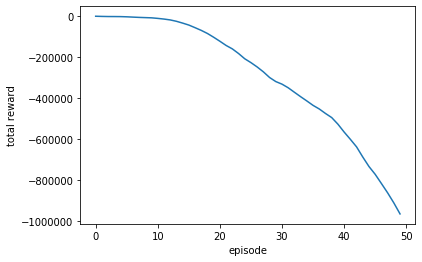

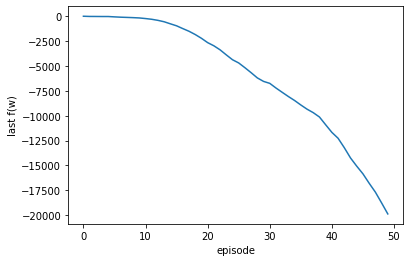

In [6]:
def f2d(w):
  x = w[0]
  y = w[1]
  return -(x-1)**2 - (y-1.5)**2
f2d_w0 = [2,1]

def f1d(w):
  return -(w[0]-1)**2 + 5

# Gradient at 1d.
# We won't have this information for complex f, but want to replicate Ke li 2017 closely.
def g1d(w):
  return np.array([-2 * (w[0]-1)])
  
f1d_w0 = [2]

optimize_with_rl(f1d, g1d, f1d_w0)